In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from keras.layers import LSTM, Activation, Dense, Dropout, Embedding, Flatten, Input, MaxPooling1D, SpatialDropout1D
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets.base import get_data_home
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=11rsquoqqd3fQk-yp210qjMu2djj12BrH'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('NSF.csv')  
dataset = pd.read_csv('NSF.csv')
# Dataset is now stored in a Pandas Dataframe

11rsquoqqd3fQk-yp210qjMu2djj12BrH


# Processamento dos Dados

```
# Tokenize the data and convert the text to sequences.
# Add padding to ensure that all the sequences have the same shape.
# There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.
```



In [0]:
#Definindo constantes
max_length = 100
num_labels = 16
vocab_size = 10000
batch_size = [100]
epochs = [10]
# Extract text
tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
tokenizer.fit_on_texts(dataset.data)
sequences = tokenizer.texts_to_sequences(dataset.data) # Generate sequences
x = pad_sequences(sequences, maxlen=max_length)
# Extract target
y = to_categorical(np.asarray(dataset.target))

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.2)

# Loading GloVe embeddings

In [0]:
link = 'https://drive.google.com/open?id=1erGe6LcwCDxpL9D8rRO7UYg0POVBvwX8'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1erGe6LcwCDxpL9D8rRO7UYg0POVBvwX8


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove.6B.100d.txt') 

In [0]:
embeddings_index = {} # We create a dictionary of word -> embedding

with open(os.path.join('glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        embeddings_index[word] = embedding # Add embedding to our embedding dictionary

print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))

Found 400,000 word vectors in GloVe.


In [0]:
embedding_dim = 100 # We use 100 dimensional glove vectors

word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index)) # How many words are there actually

embedding_matrix = np.zeros((nb_words, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= vocab_size: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [0]:
def RNN(optimizer='adam'):
    model = Sequential()
    model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    input_length=max_length, 
                    weights = [embedding_matrix], 
                    trainable = False))
    model.add(SpatialDropout1D(0.7))
    model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [0]:
model = RNN()
model.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
Total params: 1,043,280
Trainable params: 43,280
Non-trainable params: 1,000,000
_________________________________________________________________


In [0]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10)



Train on 8419 samples, validate on 2105 samples
Epoch 1/10
8419/8419 [==============================] - 59s 7ms/step - loss: 0.2250 - acc: 0.9375 - val_loss: 0.2115 - val_acc: 0.9375
Epoch 2/10
8419/8419 [==============================] - 58s 7ms/step - loss: 0.2159 - acc: 0.9375 - val_loss: 0.1938 - val_acc: 0.9376
Epoch 3/10
8419/8419 [==============================] - 58s 7ms/step - loss: 0.2095 - acc: 0.9375 - val_loss: 0.1796 - val_acc: 0.9386
Epoch 4/10
8419/8419 [==============================] - 58s 7ms/step - loss: 0.2045 - acc: 0.9376 - val_loss: 0.1715 - val_acc: 0.9387
Epoch 5/10
8419/8419 [==============================] - 57s 7ms/step - loss: 0.2003 - acc: 0.9377 - val_loss: 0.1651 - val_acc: 0.9403
Epoch 6/10
8419/8419 [==============================] - 57s 7ms/step - loss: 0.1974 - acc: 0.9377 - val_loss: 0.1595 - val_acc: 0.9419
Epoch 7/10
8419/8419 [==============================] - 58s 7ms/step - loss: 0.1941 - acc: 0.9379 - val_loss: 0.1567 - val_acc: 0.9433
Epoch

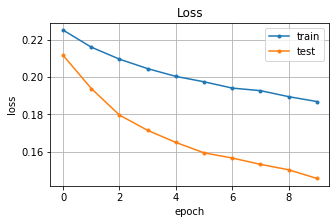

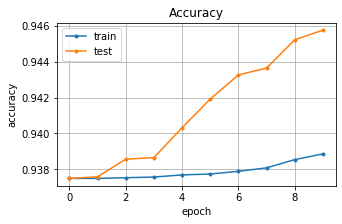

In [0]:
plt.figure(figsize =(5,3))
plt.plot(history.history['loss'], marker='.', label='train')
plt.plot(history.history['val_loss'], marker='.', label='test')
plt.title('Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize =(5,3))
plt.plot(history.history['acc'], marker='.', label='train')
plt.plot(history.history['val_acc'], marker='.', label='test')
plt.title('Accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

In [0]:
# create model
model = KerasClassifier(build_fn=RNN, epochs=10, batch_size=100, verbose=0)

In [0]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10, verbose=True, return_train_score=True)
grid_result = grid.fit(x, y)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 132.2min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 197.7min finished


In [0]:
df = pd.DataFrame(grid_result.cv_results_)
df.to_csv('resultado_LSTM_NSF.csv')
print(df.to_csv())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,328.2665383338928,2.203132116089715,1.7845173120498656,0.08728643553835859,SGD,{'optimizer': 'SGD'},0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.0,7,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.9375,0.0
1,335.36488513946534,1.7682578876097228,1.8335928440093994,0.10576505412986212,RMSprop,{'optimizer': 'RMSprop'},0.9425451063249413,0.9436134812612252,0.9423670565527276,0.9421889925161545,0.942431095661

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.945838 using {'optimizer': 'Nadam'}
0.937500 (0.000000) with: {'optimizer': 'SGD'}
0.942738 (0.000625) with: {'optimizer': 'RMSprop'}
0.940594 (0.000798) with: {'optimizer': 'Adagrad'}
0.937755 (0.000235) with: {'optimizer': 'Adadelta'}
0.943480 (0.000975) with: {'optimizer': 'Adam'}
0.940588 (0.000617) with: {'optimizer': 'Adamax'}
0.945838 (0.000999) with: {'optimizer': 'Nadam'}
